In [0]:
#dbfs:/FileStore/shared_uploads/danghia2002@gmail.com/Churn_Modelling.csv

In [0]:
#Bài 1: Lựa chọn đặc trưng
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.types import FloatType
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Đọc dữ liệu từ file CSV
data = spark.read.csv("dbfs:/FileStore/shared_uploads/danghia2002@gmail.com/Churn_Modelling.csv", header=True, inferSchema=True)


In [0]:
data.printSchema()

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [0]:
#Thống kê mô tả
data.describe().show()

+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|            5000.5|

In [0]:
#Trực quan hóa
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#Đếm số lượng khách hàng rời đi và chưa rời đi
churn_count = data.groupBy("Exited").count().orderBy("Exited")
churn_count.show()

+------+-----+
|Exited|count|
+------+-----+
|     0| 7963|
|     1| 2037|
+------+-----+



Out[28]: Text(0.5, 1.0, 'Churn Count')

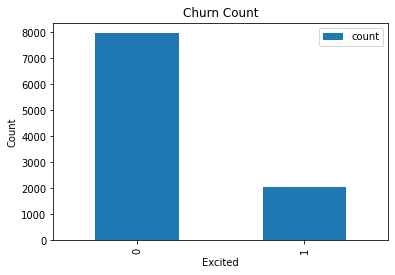

In [0]:
#Trực quan hóa số lượng khách hàng rời đi và chưa rời đi
churn_count_pd = churn_count.toPandas()
churn_count_pd.plot(kind = "bar", x = 'Exited', y = 'count')
plt.xlabel("Excited")
plt.ylabel("Count")
plt.title("Churn Count")


In [0]:
#Đếm số lượng khách hàng theo quốc gia
country_count = data.groupBy("Geography").count()
country_count.show()

+---------+-----+
|Geography|count|
+---------+-----+
|  Germany| 2509|
|   France| 5014|
|    Spain| 2477|
+---------+-----+



Out[30]: Text(0.5, 1.0, 'Number of customer by Geography')

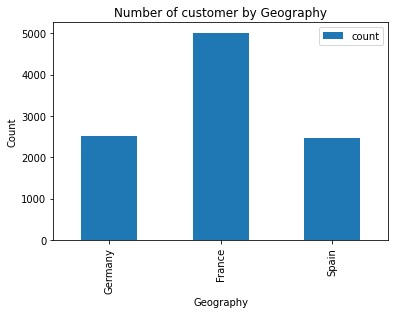

In [0]:
#Trực quan hóa số lượng khách hàng
country_count_pd = country_count.toPandas()
country_count_pd.plot(kind="bar", x = "Geography", y = "count")
plt.xlabel("Geography")
plt.ylabel("Count")
plt.title("Number of customer by Geography")

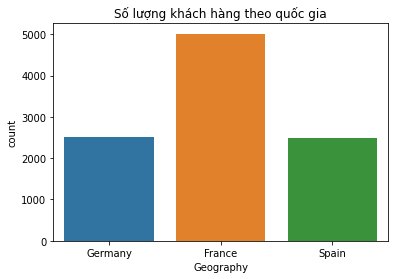

In [0]:
country_counts = data.groupBy("Geography").count().toPandas()
sns.barplot(x="Geography", y="count", data=country_counts)
plt.title("Số lượng khách hàng theo quốc gia")
plt.show()

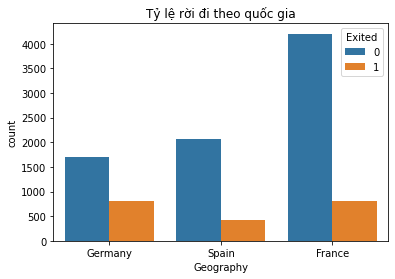

In [0]:
#Trực quan hóa tỷ lệ rời đi theo quốc gia
gender_churn = data.groupBy("Geography", "Exited").count().toPandas()
sns.barplot(x="Geography", y="count", hue="Exited", data=gender_churn)
plt.title("Tỷ lệ rời đi theo quốc gia")
plt.show()

Out[33]: <function matplotlib.pyplot.show(close=None, block=None)>

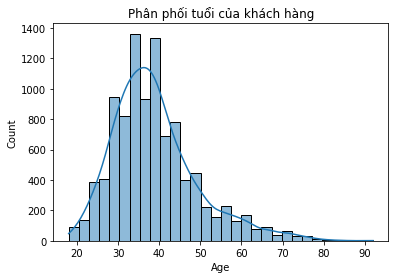

In [0]:
#Loại bỏ các giá trị NaN và chọn cột "Age"
age_distribution = data.select("Age").na.drop().toPandas()

#Sử dụng histplot thay vì hist để sử dụng hỗ trợ mới hơn từ Seaborn
sns.histplot(data=age_distribution, x="Age", bins=30, kde=True)
plt.title("Phân phối tuổi của khách hàng")
plt.show


In [0]:
#Tiền xử lý dữ liệu và tạo cột features
#Loại bỏ cột RowNumber, CustomerID
data_processed = data.drop('RowNumber', 'CustomerID', 'Surname')
data_processed.printSchema()

root
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



In [0]:
#Chuyển đổi giá trị chuỗi thành số
string_columns = ["Geography", "Gender"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(data) for col in string_columns]
data_transformed = data_processed
for indexer in indexers:
    data_transformed = indexer.transform(data_transformed)

#Hiển thị DataFrame sau khi chuyển đổi giá trị chuỗi thành số
data_transformed.show()


+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|Geography_index|Gender_index|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+---------------+------------+
|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|            0.0|         1.0|
|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|            2.0|         1.0|
|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|            0.0|         1.0|
|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|            0.0|         1.0|

In [0]:
#Loại bỏ cột không cần thiết
columns_to_drop = ["RowNumber", "CustomerId", "Surname"]
data = data.drop(*columns_to_drop)


In [0]:

#Chuyển đổi giá trị chuỗi thành số cho cột "Geography"
geography_indexer = StringIndexer(inputCol="Geography", outputCol="GeographyIndex")
data = geography_indexer.fit(data).transform(data)


In [0]:

#Chuyển đổi giá trị chuỗi thành số cho cột "Gender"
gender_indexer = StringIndexer(inputCol="Gender", outputCol="GenderIndex")
data = gender_indexer.fit(data).transform(data)


In [0]:

#Chuyển đổi các cột số từ chuỗi thành số thực
numeric_columns = ["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "HasCrCard", "IsActiveMember", "EstimatedSalary", "Exited"]
for col_name in numeric_columns:
    data = data.withColumn(col_name, data[col_name].cast(FloatType()))


In [0]:

#Hiển thị schema của DataFrame sau khi tiền xử lý
data.printSchema()


root
 |-- CreditScore: float (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: float (nullable = true)
 |-- Tenure: float (nullable = true)
 |-- Balance: float (nullable = true)
 |-- NumOfProducts: float (nullable = true)
 |-- HasCrCard: float (nullable = true)
 |-- IsActiveMember: float (nullable = true)
 |-- EstimatedSalary: float (nullable = true)
 |-- Exited: float (nullable = true)
 |-- GeographyIndex: double (nullable = false)
 |-- GenderIndex: double (nullable = false)



In [0]:

#Chuyển đổi các biến độc lập thành vector
feature_columns = ["GeographyIndex", "GenderIndex"] + numeric_columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(data)
#Hiển thị DataFrame sau khi chuyển đổi thành vector
data.select("features", "Exited").show(truncate=False)

+------------------------------------------------------------------+------+
|features                                                          |Exited|
+------------------------------------------------------------------+------+
|[0.0,1.0,619.0,42.0,2.0,0.0,1.0,1.0,1.0,101348.8828125]           |1.0   |
|[2.0,1.0,608.0,41.0,1.0,83807.859375,1.0,0.0,1.0,112542.578125]   |0.0   |
|[0.0,1.0,502.0,42.0,8.0,159660.796875,3.0,1.0,0.0,113931.5703125] |1.0   |
|[0.0,1.0,699.0,39.0,1.0,0.0,2.0,0.0,0.0,93826.6328125]            |0.0   |
|[2.0,1.0,850.0,43.0,2.0,125510.8203125,1.0,1.0,1.0,79084.1015625] |0.0   |
|[2.0,0.0,645.0,44.0,8.0,113755.78125,2.0,1.0,0.0,149756.703125]   |1.0   |
|[0.0,0.0,822.0,50.0,7.0,0.0,2.0,1.0,1.0,10062.7998046875]         |0.0   |
|[1.0,1.0,376.0,29.0,4.0,115046.7421875,4.0,1.0,0.0,119346.8828125]|1.0   |
|[0.0,0.0,501.0,44.0,4.0,142051.0625,2.0,0.0,1.0,74940.5]          |0.0   |
|[0.0,0.0,684.0,27.0,2.0,134603.875,1.0,1.0,1.0,71725.7265625]     |0.0   |
|[0.0,0.0,52

In [0]:
#Chia dữ liệu train và test
data_train, data_test = data.randomSplit([0.7, 0.3], seed=666)

In [0]:
#Tạo mô hình Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Exited")

#Huấn luyện mô hình trên tập huấn luyện
lr_model = lr.fit(data_train)


In [0]:
#Dự đoán trên tập kiểm tra
predictions = lr_model.transform(data_test)
predictions.show()

+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+--------------+-----------+--------------------+--------------------+--------------------+----------+
|CreditScore|Geography|Gender| Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|GeographyIndex|GenderIndex|            features|       rawPrediction|         probability|prediction|
+-----------+---------+------+----+------+---------+-------------+---------+--------------+---------------+------+--------------+-----------+--------------------+--------------------+--------------------+----------+
|      365.0|  Germany|  Male|30.0|   0.0|127760.07|          1.0|      1.0|           0.0|       81537.85|   1.0|           1.0|        0.0|[1.0,0.0,365.0,30...|[1.50828809781497...|[0.81880736444886...|       0.0|
|      373.0|   France|  Male|42.0|   7.0|      0.0|          1.0|      1.0|           0.0|       77786.37|   1.0|           0.0|       

In [0]:
predictions.take(2)

Out[48]: [Row(CreditScore=365.0, Geography='Germany', Gender='Male', Age=30.0, Tenure=0.0, Balance=127760.0703125, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=0.0, EstimatedSalary=81537.8515625, Exited=1.0, GeographyIndex=1.0, GenderIndex=0.0, features=DenseVector([1.0, 0.0, 365.0, 30.0, 0.0, 127760.0703, 1.0, 1.0, 0.0, 81537.8516]), rawPrediction=DenseVector([1.5083, -1.5083]), probability=DenseVector([0.8188, 0.1812]), prediction=0.0),
 Row(CreditScore=373.0, Geography='France', Gender='Male', Age=42.0, Tenure=7.0, Balance=0.0, NumOfProducts=1.0, HasCrCard=1.0, IsActiveMember=0.0, EstimatedSalary=77786.3671875, Exited=1.0, GeographyIndex=0.0, GenderIndex=0.0, features=DenseVector([0.0, 0.0, 373.0, 42.0, 7.0, 0.0, 1.0, 1.0, 0.0, 77786.3672]), rawPrediction=DenseVector([1.3363, -1.3363]), probability=DenseVector([0.7919, 0.2081]), prediction=0.0)]

In [0]:
from pyspark.ml import PipelineModel
from pyspark.sql import SparkSession



In [0]:

#Tạo Spark session
spark = SparkSession.builder.appName("ChurnModellingPrediction").getOrCreate()


---------------------------------------------------------------------------
Py4JJavaError                             Traceback (most recent call last)
File <command-2952072165482096>:3
      1 #Load mô hình
      2 saved_model_path = "path_to_save_model"
----> 3 loaded_model = PipelineModel.load("/content/model77.csv")

File /databricks/spark/python/pyspark/ml/util.py:447, in MLReadable.load(cls, path)
    444 @classmethod
    445 def load(cls, path: str) -> RL:
    446     """Reads an ML instance from the input path, a shortcut of `read().load(path)`."""
--> 447     return cls.read().load(path)

File /databricks/spark/python/pyspark/ml/pipeline.py:282, in PipelineModelReader.load(self, path)
    281 def load(self, path: str) -> "PipelineModel":
--> 282     metadata = DefaultParamsReader.loadMetadata(path, self.sc)
    283     if "language" not in metadata["paramMap"] or metadata["paramMap"]["language"] != "Python":
    284         return JavaMLReader(cast(Type["JavaMLReadable[Pipelin